<a href="https://colab.research.google.com/github/AtriBh/GAN/blob/main/FashionMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from numpy.random import randint,randn
from tensorflow.keras.layers import Concatenate,Reshape,Embedding,Conv2D,Conv2DTranspose,Dense,Flatten,Dropout,LeakyReLU,Input
from tensorflow.keras.models import Model
from tensorflow.keras.datasets.fashion_mnist import load_data
from numpy import ones,zeros

In [ ]:
def define_generator(latent_dim, n_classes=10):

	# label input
	in_label = Input(shape=(1,))  #Input of dimension 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50.
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50

	# linear multiplication
	n_nodes = 7 * 7  # To match the dimensions for concatenation later in this step.
	li = Dense(n_nodes)(li) #1,64
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)


	# image generator input
	in_lat = Input(shape=(latent_dim,))  #Input of dimension 100

	# foundation for 8x8 image
    # We will reshape input latent vector into 7x7 image as a starting point.
    #So n_nodes for the Dense layer can be 128x7x7 so when we reshape the output
    #it would be 8x8x128 and that can be slowly upscaled to 28x28 image for output.
    #Note that this part is same as unconditional GAN until the output layer.
    #While defining model inputs we will combine input label and the latent input.
	n_nodes = 128*7*7
	gen = Dense(n_nodes)(in_lat)  #shape=8192
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen) #Shape=8x8x128
	# merge image gen and label input
	merge = Concatenate()([gen, li])  #Shape=8x8x129 (Extra channel corresponds to the label)
	# upsample to 16x16
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge) #16x16x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 32x32
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen) #32x32x128
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (8,8), activation='sigmoid', padding='same')(gen) #32x32x3
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model   #Model not compiled as it is not directly trained like the discriminator.



In [ ]:
gen=define_generator(100)

In [ ]:
gen.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 input_17 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 dense_17 (Dense)            (None, 6272)                 633472    ['input_18[0][0]']            
                                                                                                  
 embedding_8 (Embedding)     (None, 1, 50)                500       ['input_17[0][0]']            
                                                                                           

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
def define_discriminator(in_shape=(28,28,1), n_classes=10):

    # label input
	in_label = Input(shape=(1,))  #Shape 1
	# embedding for categorical input
    #each label (total 10 classes for cifar), will be represented by a vector of size 50.
    #This vector of size 50 will be learnt by the discriminator
	li = Embedding(n_classes, 50)(in_label) #Shape 1,50
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]  #28x28
	li = Dense(n_nodes)(li)  #Shape = 1, 28x28
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)  #32x32x1


	# image input
	in_image = Input(shape=in_shape) #28x28x1
	# concat label as a channel
	merge = Concatenate()([in_image, li]) #28x28x1 (4 channels, 3 for image and the other for labels)

	# downsample: This part is same as unconditional GAN upto the output layer.
    #We will combine input label with input image and supply as inputs to the model.
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge) #14x14x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe) #7x7x128
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)  #  (7*7*128)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)  #Shape=1

	# define model
    ##Combine input label with input image and supply as inputs to the model.
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model



In [ ]:
dis=define_discriminator()

In [ ]:
dis.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 1, 50)                500       ['input_19[0][0]']            
                                                                                                  
 dense_18 (Dense)            (None, 1, 784)               39984     ['embedding_9[0][0]']         
                                                                                                  
 input_20 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                           

In [ ]:
def define_gan(g_model, d_model):
	d_model.trainable = False  #Discriminator is trained separately. So set to not trainable.

    ## connect generator and discriminator...
	# first, get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input  #Latent vector size and label size
	# get image output from the generator model
	gen_output = g_model.output  #32x32x3

	# generator image output and corresponding input label are inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()   #cifar
	# convert to floats and scale
	X = trainX.astype('float32')
	# scale from [0,255] to [0,1]
	X = X/255.0   #Generator uses sigmoid activation so rescale
                            #original images to  0 to 1 to match the output of generator.
	return [X, trainy]

# # select real samples
# pick a batch of random real samples to train the GAN
#In fact, we will train the GAN on a half batch of real images and another
#half batch of fake images.
#For each real image we assign a label 1 and for fake we assign label 0.
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels and assign to y (don't confuse this with the above labels that correspond to cifar labels)
	y = ones((n_samples, 1))  #Label=1 indicating they are real
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
#Supply the generator, latent_dim and number of samples as input.
#Use the above latent point generator to generate latent points.
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return [images, labels_input], y


In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    history = {"d_loss": [], "g_loss": []}

    for i in range(n_epochs):
        for j in range(bat_per_epo):
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            d_loss_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)

            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            d_total = d_loss_real + d_loss_fake

            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            y_gan = ones((n_batch, 1))

            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            history["d_loss"].append(d_total)
            history["g_loss"].append(g_loss)
            print('Epoch>%d, Batch%d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                  (i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
    # save the generator model
    g_model.save('conditional_generator_50epochs.h5')
    d_model.save('conditional_discriminator_50epochs.h5')
    gan_model.save('conditional_gan_50epochs.h5')
    return history



In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
hist=train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50)

Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 6ms/step
Epoch>45, Batch309/468, d1=0.696, d2=0.692 g=0.739
2/2 [==============================] - 0s 6ms/step
Epoch>45, Batch310/468, d1=0.689, d2=0.655 g=0.765
2/2 [==============================] - 0s 11ms/step
Epoch>45, Batch311/468, d1=0.698, d2=0.669 g=0.766
2/2 [==============================] - 0s 9ms/step
Epoch>45, Batch312/468, d1=0.696, d2=0.651 g=0.767
2/2 [==============================] - 0s 6ms/step
Epoch>45, Batch313/468, d1=0.681, d2=0.656 g=0.731
2/2 [==============================] - 0s 7ms/step
Epoch>45, Batch314/468, d1=0.688, d2=0.671 g=0.762
2/2 [==============================] - 0s 7ms/step
Epoch>45, Batch315/468, d1=0.691, d2=0.663 g=0.733
2/2 [==============================] - 0s 7ms/step
Epoch>45, Batch316/468, d1=0.679, d2=0.711 g=0.735
2/2 [==============================] - 0s 5ms/step
Epoch>45, Batch317/468, d1=0.658, d2=0.707 g=0.737
2/2 [=========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch>50, Batch468/468, d1=0.692, d2=0.690 g=0.744


In [ ]:
hist

{'d_loss': [1.4361125230789185,
  1.3891759514808655,
  1.361073076725006,
  1.3406351804733276,
  1.3237176537513733,
  1.2946547865867615,
  1.2820783853530884,
  1.2499666213989258,
  1.2390319108963013,
  1.2327210903167725,
  1.2142749428749084,
  1.2044577598571777,
  1.1996360421180725,
  1.1905298829078674,
  1.1865947246551514,
  1.1469970345497131,
  1.1602362394332886,
  1.1055771112442017,
  1.056653916835785,
  1.0111373662948608,
  0.9852548241615295,
  0.9371945410966873,
  0.9143349230289459,
  0.8839230388402939,
  0.8556490838527679,
  0.8284255266189575,
  0.7845912352204323,
  0.7793400585651398,
  0.726244643330574,
  0.7287591248750687,
  0.6792415305972099,
  0.66067124158144,
  0.6243101321160793,
  0.594391692429781,
  0.5782734006643295,
  0.5480488985776901,
  0.5092054903507233,
  0.44207121804356575,
  0.42761869728565216,
  0.3848787918686867,
  0.34879688173532486,
  0.2547219470143318,
  0.26624611392617226,
  0.21125881373882294,
  0.19764938205480576,


Text(0.5, 1.0, 'g_loss')

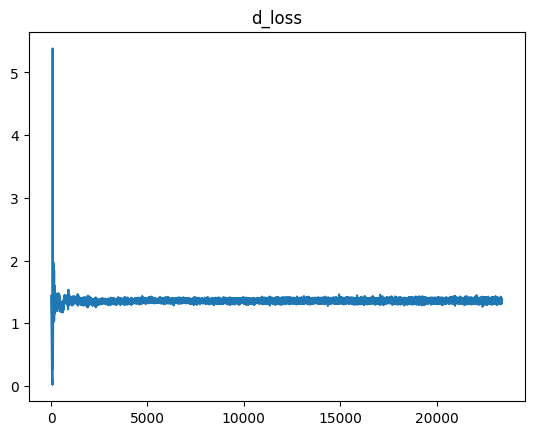

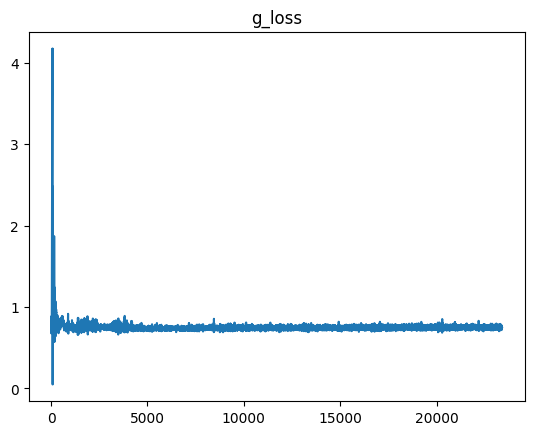

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(hist["d_loss"])
plt.title("d_loss")
plt.figure()
plt.plot(hist["g_loss"])
plt.title("g_loss")

In [ ]:
[fakeimg,_],_=generate_fake_samples(g_model,100,10)

1/1 [==============================] - 0s 26ms/step


In [ ]:
fakeimg[1]

array([[[8.80439813e-07],
        [6.27795907e-06],
        [1.42982011e-04],
        [9.78506170e-04],
        [5.87835675e-03],
        [2.20824741e-02],
        [4.53911629e-03],
        [6.11159578e-02],
        [1.08529814e-01],
        [3.48609462e-02],
        [5.22473752e-02],
        [4.28427616e-03],
        [1.04540924e-03],
        [7.56131532e-03],
        [1.49806468e-02],
        [3.05430684e-03],
        [4.28215507e-03],
        [3.12484711e-01],
        [5.82510114e-01],
        [9.56470743e-02],
        [4.32134839e-03],
        [2.53899558e-03],
        [1.24278286e-05],
        [2.54251981e-10],
        [1.47529206e-13],
        [1.34954439e-14],
        [1.55171997e-14],
        [4.65984917e-10]],

       [[3.58403515e-11],
        [4.62437033e-10],
        [1.65088318e-06],
        [3.07979531e-06],
        [3.36504002e-07],
        [2.90405369e-05],
        [3.59896268e-03],
        [4.75862175e-02],
        [2.18854994e-01],
        [7.49038979e-02],
        [9

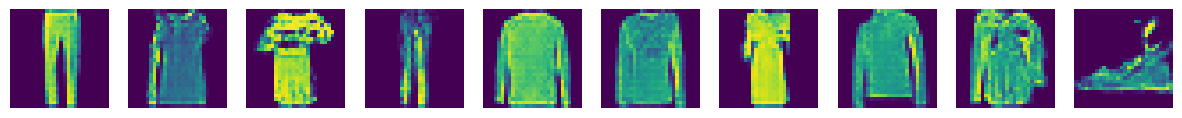

In [ ]:
fig,ax=plt.subplots(ncols=10,figsize=(15,15))
for i in range(10):
  ax[i].imshow(fakeimg[i])
  ax[i].axis(False)

In [ ]:
noise_list=generate_latent_points(100,3)

In [ ]:
gan_model.predict(noise_list)

1/1 [==============================] - 0s 301ms/step


array([[0.4791544 ],
       [0.46783072],
       [0.42682546]], dtype=float32)